Adaptive Distances
==================

For illustration, we consider a simple Gaussian model:

In [2]:
import scipy
import tempfile
import os
import matplotlib.pyplot as pyplot
import pyabc.visualization
import logging


# for debugging
df_logger = logging.getLogger('DistanceFunction')
df_logger.setLevel(logging.DEBUG)

# model definition
def model(p):
    return {'ss1': p['theta'] + 1 + 0.1*scipy.randn(),
            'ss2': 2 + 10*scipy.randn()}

# true model parameter
theta_true = 3

# observed summary statistics
observation = {'ss1': theta_true + 1, 'ss2': 2}

# prior distribution
prior = pyabc.Distribution(theta=pyabc.RV('uniform', 0, 10))

Summary statistic ss2 has a high variance compared to summary statistic ss1. In addition, ss1 is informative about the model parameters $\theta$, ss2 not. We expect that the proposal distribution for $\theta$ iteratively centers around the true value $\theta=3$. Thus, the variability for the sampled ss1 decreases iteratively, while the variability of the sampled ss2 stays approximately constant. If both summary statistics are weighted similarly in the calculation of the distance between sample and observation, there is hence an undesirable high impact of ss2, so that convergence can be slowed down. In contrast, if we weight ss1 higher, we may hope that our estimation of $\theta$ is improved.

These informal expectations being stated, let us continue with the implementation. First, we consider a non-adaptive Euclidean distance:

In [3]:
distance = pyabc.PNormDistance(p=2)

abc = pyabc.ABCSMC(model, prior, distance)
db_path = "sqlite:///" + os.path.join(tempfile.gettempdir(), "as1.db")
abc.new(db_path, observation)
history1 = abc.run(minimum_epsilon=.1, max_nr_populations=8)

INFO:Epsilon:initial epsilon is 6.4298450690121
INFO:History:Start <ABCSMC(id=1, start_time=2018-04-08 21:57:39.290746, end_time=None)>
INFO:ABC:t:0 eps:6.4298450690121
INFO:ABC:t:1 eps:4.230739381443604
INFO:ABC:t:2 eps:3.0299143715704617
INFO:ABC:t:3 eps:2.161100739564889
INFO:ABC:t:4 eps:1.5132837481716868
INFO:ABC:t:5 eps:1.012817089032395
INFO:ABC:t:6 eps:0.7610550475354283
INFO:ABC:t:7 eps:0.5397221372302345
INFO:History:Done <ABCSMC(id=1, start_time=2018-04-08 21:57:39.290746, end_time=2018-04-08 21:59:42.588179)>


Let us visualize the results for the non-adaptive distance:

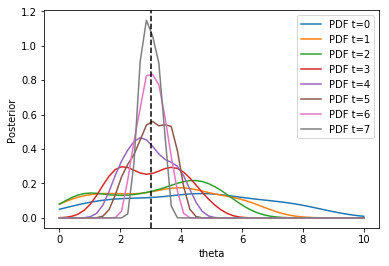

In [4]:
fig, ax = pyplot.subplots()
for t in range(history1.max_t + 1):
    df, w = history1.get_distribution(m=0, t=t)
    pyabc.visualization.plot_kde_1d(df, w, xmin=0, xmax=10,
                                   x='theta', ax=ax,
                                   label="PDF t={}".format(t))
ax.axvline(theta_true, color='k', linestyle='dashed')
ax.legend()
pyplot.show()

Second, we consider an adaptive Euclidean distance:

In [5]:
distance = pyabc.WeightedPNormDistance(p=2, adaptive=True)

abc = pyabc.ABCSMC(model, prior, distance)
db_path = "sqlite:///" + os.path.join(tempfile.gettempdir(), "as2.db")
abc.new(db_path, observation)
history2 = abc.run(minimum_epsilon=.1, max_nr_populations=8)

DEBUG:DistanceFunction:update distance weights = {'ss1': 1.4187259777846606, 'ss2': 0.58127402221533953}
INFO:Epsilon:initial epsilon is 6.509756059652932
INFO:History:Start <ABCSMC(id=1, start_time=2018-04-08 21:59:45.810950, end_time=None)>
INFO:ABC:t:0 eps:6.509756059652932
DEBUG:DistanceFunction:update distance weights = {'ss1': 1.4518084273224778, 'ss2': 0.54819157267752194}
INFO:ABC:t:1 eps:3.6674824345627948
DEBUG:DistanceFunction:update distance weights = {'ss1': 1.5873576038620378, 'ss2': 0.41264239613796211}
INFO:ABC:t:2 eps:2.4245635050823315
DEBUG:DistanceFunction:update distance weights = {'ss1': 1.670637901009864, 'ss2': 0.32936209899013613}
INFO:ABC:t:3 eps:1.5462881336949525
DEBUG:DistanceFunction:update distance weights = {'ss1': 1.8149531902434992, 'ss2': 0.18504680975650081}
INFO:ABC:t:4 eps:0.8714560474616164
DEBUG:DistanceFunction:update distance weights = {'ss1': 1.8882586549957754, 'ss2': 0.11174134500422481}
INFO:ABC:t:5 eps:0.4832134765052389
DEBUG:DistanceFunc

In the debug output of abc.run above, it can be seen how the weights evolve over time. Let us visualize the results for the adaptive distance:

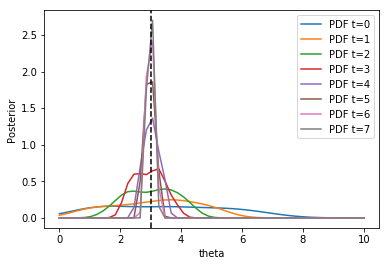

In [6]:
fig, ax = pyplot.subplots()
for t in range(history2.max_t + 1):
    df, w = history2.get_distribution(m=0, t=t)
    pyabc.visualization.plot_kde_1d(df, w, xmin=0, xmax=10,
                                   x='theta', ax=ax,
                                   label="PDF t={}".format(t))
ax.axvline(theta_true, color='k', linestyle='dashed')
ax.legend()
pyplot.show()

We observe differences compared to the non-adaptive setting. In particular, the densitities tend to be narrower around the true parameter $\theta=3$.